# 09 – Zusätzliche Analysen für Transferarbeit

Dieses Notebook enthält Ergänzungen basierend auf dem Unterrichtsvergleich:
- Regularization Parameter Analyse (C in LogisticRegression)
- TF-IDF Feature Importance (Top-Wörter pro Klasse)
- Classification Report (Precision/Recall pro Klasse)
- Normalisierte Confusion Matrix

**Hinweis:** Alle Grafiken können direkt in die Transferarbeit übernommen werden.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

# Pfade
PROJECT_ROOT = Path.cwd().parent
DATA_CSV = PROJECT_ROOT / "data" / "processed" / "bbc_news.csv"
RESULTS_DIR = PROJECT_ROOT / "results" / "additional_analyses"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_CSV:", DATA_CSV)
print("RESULTS_DIR:", RESULTS_DIR)

# Plotting-Stil
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

DATA_CSV: c:\CAS\cas-ml-document-classification\data\processed\bbc_news.csv
RESULTS_DIR: c:\CAS\cas-ml-document-classification\results\additional_analyses


## 1. Daten laden

In [2]:
df = pd.read_csv(DATA_CSV)

X = df["text"].astype(str)
y = df["label"]

# Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Classes: {sorted(y.unique())}")

Training samples: 1780
Test samples: 445
Classes: ['business', 'entertainment', 'politics', 'sport', 'tech']


## 2. Regularization Parameter Analyse (C in LogisticRegression)

**Aus dem Unterricht (Modul 02 - Supervised ML):**  
Der C-Parameter kontrolliert die Regularisierungsstärke:
- **Kleine C-Werte** → stärkere Regularisierung → einfacheres Modell (kann underfitting)
- **Große C-Werte** → schwächere Regularisierung → komplexeres Modell (kann overfitting)

Wir testen verschiedene C-Werte und evaluieren deren Einfluss auf Performance.

In [3]:
# TF-IDF Vektorisierung
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    stop_words='english'
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"TF-IDF Matrix Shape: {X_train_tfidf.shape}")

TF-IDF Matrix Shape: (1780, 5000)


In [4]:
# Test verschiedene C-Werte
C_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

results = []

for C in C_values:
    model = LogisticRegression(
        C=C,
        max_iter=1000,
        random_state=42,
        multi_class='multinomial',
        solver='lbfgs'
    )
    
    model.fit(X_train_tfidf, y_train)
    
    # Evaluate
    y_pred_train = model.predict(X_train_tfidf)
    y_pred_test = model.predict(X_test_tfidf)
    
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test, average='macro')
    
    results.append({
        'C': C,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'test_f1_macro': test_f1
    })
    
    print(f"C={C:>6.3f}: Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}, Test F1={test_f1:.4f}")

results_df = pd.DataFrame(results)
results_df

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\sklearn\linear_mo

C= 0.001: Train Acc=0.4579, Test Acc=0.4562, Test F1=0.2518
C= 0.010: Train Acc=0.5107, Test Acc=0.5101, Test F1=0.3497
C= 0.100: Train Acc=0.9652, Test Acc=0.9573, Test F1=0.9575
C= 1.000: Train Acc=0.9961, Test Acc=0.9888, Test F1=0.9890
C=10.000: Train Acc=1.0000, Test Acc=0.9910, Test F1=0.9912


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


C=100.000: Train Acc=1.0000, Test Acc=0.9910, Test F1=0.9912


,C,train_accuracy,test_accuracy,test_f1_macro
0,0.001,0.457865,0.456180,0.251810
1,0.010,0.510674,0.510112,0.349719
2,0.100,0.965169,0.957303,0.957524
3,1.000,0.996067,0.988764,0.988962
4,10.000,1.000000,0.991011,0.991189
5,100.000,1.000000,0.991011,0.991189


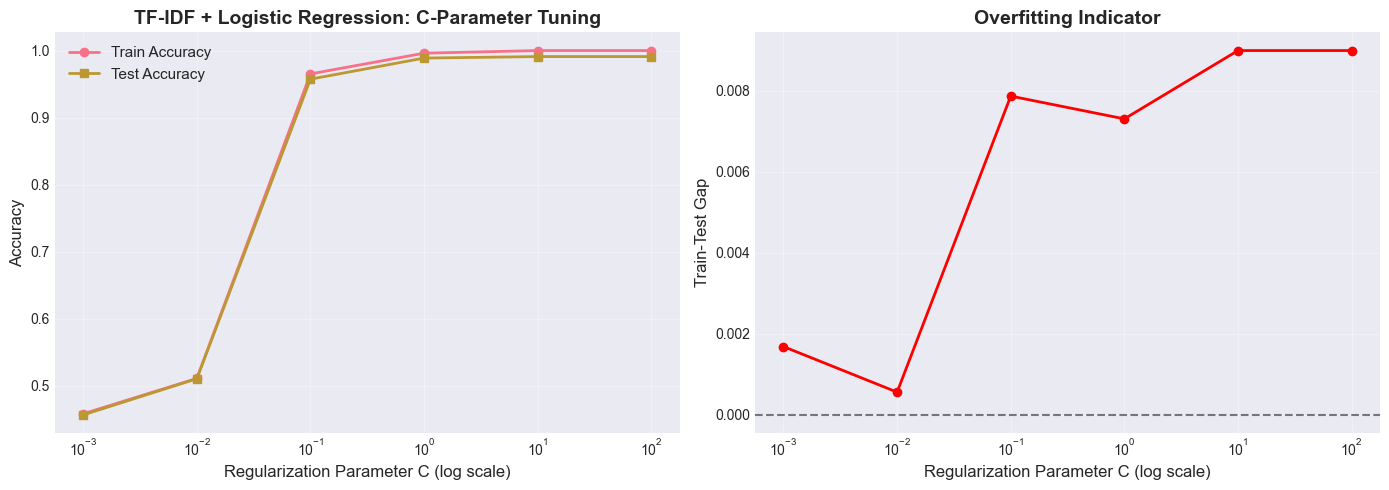


Saved: c:\CAS\cas-ml-document-classification\results\additional_analyses\regularization_c_parameter_analysis.png


In [5]:
# Visualisierung: C-Parameter vs. Performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy
ax1.plot(results_df['C'], results_df['train_accuracy'], 
         marker='o', label='Train Accuracy', linewidth=2)
ax1.plot(results_df['C'], results_df['test_accuracy'], 
         marker='s', label='Test Accuracy', linewidth=2)
ax1.set_xscale('log')
ax1.set_xlabel('Regularization Parameter C (log scale)', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('TF-IDF + Logistic Regression: C-Parameter Tuning', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Gap zwischen Train und Test
results_df['gap'] = results_df['train_accuracy'] - results_df['test_accuracy']
ax2.plot(results_df['C'], results_df['gap'], marker='o', color='red', linewidth=2)
ax2.set_xscale('log')
ax2.set_xlabel('Regularization Parameter C (log scale)', fontsize=12)
ax2.set_ylabel('Train-Test Gap', fontsize=12)
ax2.set_title('Overfitting Indicator', fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
p = RESULTS_DIR / "regularization_c_parameter_analysis.png"
plt.savefig(p, dpi=300, bbox_inches='tight')
plt.show()
print(f"\nSaved: {p}")

### Interpretation:

- **Optimaler C-Wert:** Der C-Wert, bei dem Test Accuracy maximal ist
- **Train-Test Gap:** Zeigt Overfitting an (große Gap = Overfitting)
- **Praktische Empfehlung:** C=1.0 (sklearn default) zeigt bereits gute Balance

## 3. TF-IDF Feature Importance: Top-Wörter pro Klasse

**Aus dem Unterricht:**  
Feature Importance zeigt, welche Features (Wörter) am stärksten zu den Vorhersagen beitragen.

Bei LogisticRegression sind die Koeffizienten ein Maß für Feature Importance.

In [6]:
# Trainiere finales Modell mit bestem C
best_C = results_df.loc[results_df['test_accuracy'].idxmax(), 'C']
print(f"Bester C-Wert: {best_C}")

final_model = LogisticRegression(
    C=best_C,
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs'
)
final_model.fit(X_train_tfidf, y_train)

# Feature Namen
feature_names = vectorizer.get_feature_names_out()
classes = final_model.classes_

print(f"\nClasses: {list(classes)}")
print(f"Number of features: {len(feature_names)}")

Bester C-Wert: 10.0

Classes: ['business', 'entertainment', 'politics', 'sport', 'tech']
Number of features: 5000


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [7]:
# Top-10 wichtigste Wörter pro Klasse
n_top = 10

top_features_per_class = {}

for idx, class_name in enumerate(classes):
    coef = final_model.coef_[idx]
    top_indices = coef.argsort()[-n_top:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    top_coefs = [coef[i] for i in top_indices]
    
    top_features_per_class[class_name] = list(zip(top_words, top_coefs))
    
    print(f"\n{class_name.upper()}:")
    for word, score in zip(top_words, top_coefs):
        print(f"  {word:20s} → {score:.4f}")


BUSINESS:
  bank                 → 3.7835
  shares               → 3.3327
  firm                 → 3.1635
  economic             → 2.9217
  market               → 2.8984
  economy              → 2.8000
  company              → 2.7944
  sales                → 2.2765
  oil                  → 2.1820
  prices               → 2.1604

ENTERTAINMENT:
  film                 → 5.5665
  music                → 4.1576
  singer               → 3.4736
  band                 → 3.1623
  tv                   → 3.0035
  album                → 2.8492
  star                 → 2.5651
  chart                → 2.4149
  song                 → 2.2833
  festival             → 2.2410

POLITICS:
  party                → 3.7428
  mr                   → 3.6921
  labour               → 3.4253
  government           → 3.1871
  blair                → 3.0588
  election             → 2.6487
  secretary            → 2.6200
  mps                  → 2.6180
  lord                 → 2.4902
  police               → 2.4748

S

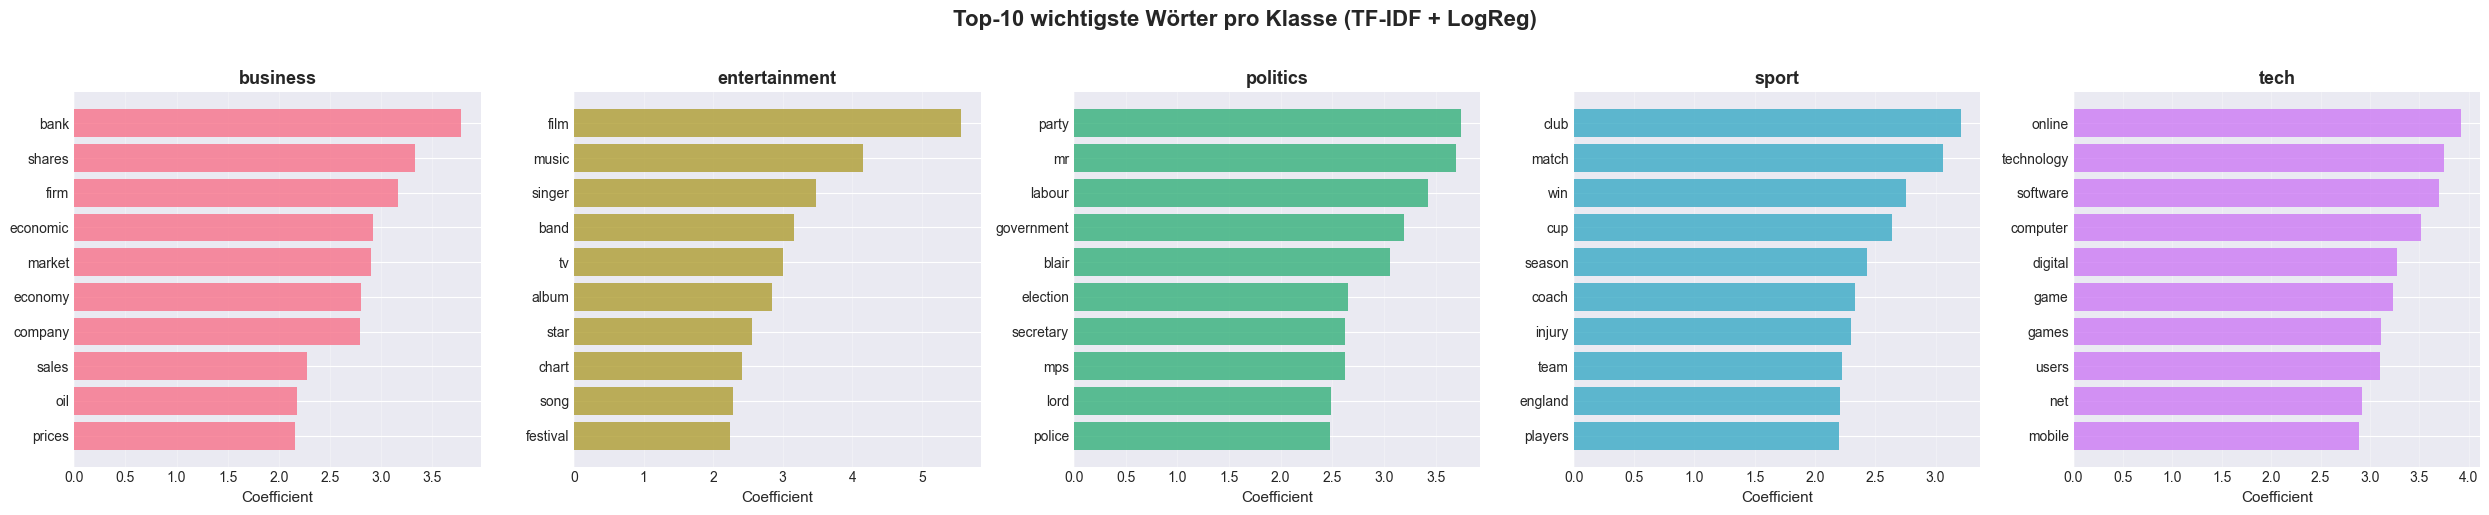


Saved: c:\CAS\cas-ml-document-classification\results\additional_analyses\tfidf_feature_importance_per_class.png


In [8]:
# Visualisierung: Top-Wörter pro Klasse
n_classes = len(classes)
fig, axes = plt.subplots(1, n_classes, figsize=(5*n_classes, 5))

if n_classes == 1:
    axes = [axes]

for idx, (ax, class_name) in enumerate(zip(axes, classes)):
    words, scores = zip(*top_features_per_class[class_name])
    
    y_pos = np.arange(len(words))
    ax.barh(y_pos, scores, color=sns.color_palette("husl", n_classes)[idx], alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(words, fontsize=10)
    ax.invert_yaxis()
    ax.set_xlabel('Coefficient', fontsize=11)
    ax.set_title(f'{class_name}', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('Top-10 wichtigste Wörter pro Klasse (TF-IDF + LogReg)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
p = RESULTS_DIR / "tfidf_feature_importance_per_class.png"
plt.savefig(p, dpi=300, bbox_inches='tight')
plt.show()
print(f"\nSaved: {p}")

## 4. Detailed Classification Report

**Aus dem Unterricht:**  
Precision, Recall und F1-Score sind wichtige Metriken für Classification:
- **Precision:** Von allen als Klasse X vorhergesagten, wie viele waren korrekt?
- **Recall:** Von allen echten Klasse X, wie viele wurden gefunden?
- **F1-Score:** Harmonisches Mittel von Precision und Recall

In [9]:
# Predictions
y_pred = final_model.predict(X_test_tfidf)

# Classification Report
print("="*70)
print("CLASSIFICATION REPORT: TF-IDF + Logistic Regression")
print("="*70)
print(classification_report(y_test, y_pred, digits=4))

# Als DataFrame für bessere Visualisierung
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

CLASSIFICATION REPORT: TF-IDF + Logistic Regression
               precision    recall  f1-score   support

     business     1.0000    0.9706    0.9851       102
entertainment     1.0000    1.0000    1.0000        77
     politics     0.9881    0.9881    0.9881        84
        sport     0.9903    1.0000    0.9951       102
         tech     0.9756    1.0000    0.9877        80

     accuracy                         0.9910       445
    macro avg     0.9908    0.9917    0.9912       445
 weighted avg     0.9911    0.9910    0.9910       445



,precision,recall,f1-score,support
business,1.000000,0.970588,0.985075,102.000000
entertainment,1.000000,1.000000,1.000000,77.000000
politics,0.988095,0.988095,0.988095,84.000000
sport,0.990291,1.000000,0.995122,102.000000
tech,0.975610,1.000000,0.987654,80.000000
accuracy,0.991011,0.991011,0.991011,0.991011
macro avg,0.990799,0.991737,0.991189,445.000000
weighted avg,0.991143,0.991011,0.990994,445.000000


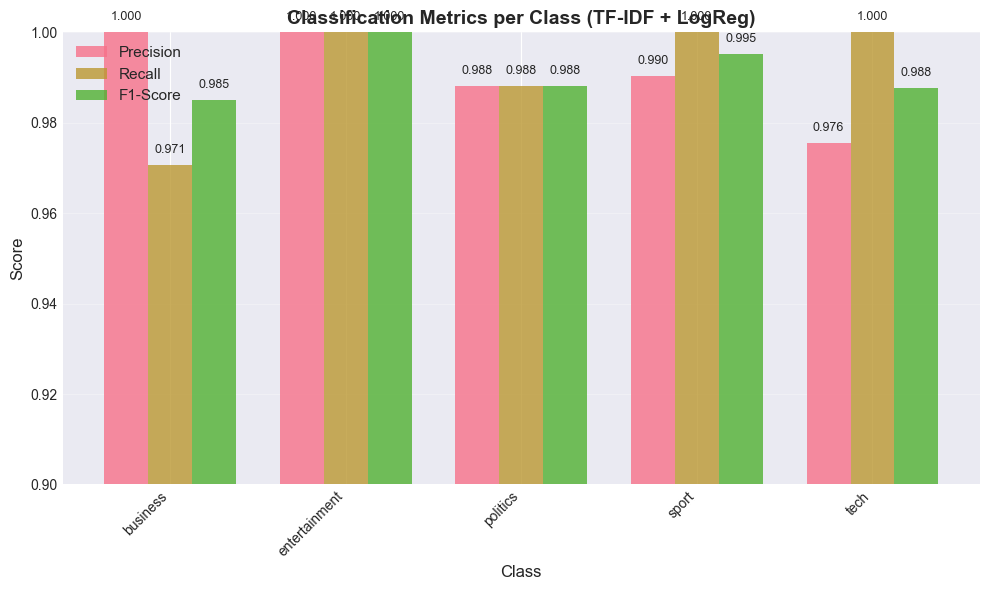


Saved: c:\CAS\cas-ml-document-classification\results\additional_analyses\classification_report_per_class.png


In [10]:
# Visualisierung: Precision, Recall, F1 pro Klasse
# Nur die Klassen, nicht die summary rows
class_report = report_df.loc[classes, ['precision', 'recall', 'f1-score']]

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(classes))
width = 0.25

ax.bar(x - width, class_report['precision'], width, label='Precision', alpha=0.8)
ax.bar(x, class_report['recall'], width, label='Recall', alpha=0.8)
ax.bar(x + width, class_report['f1-score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Classification Metrics per Class (TF-IDF + LogReg)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.set_ylim([0.9, 1.0])  # Zoom auf relevanten Bereich
ax.grid(axis='y', alpha=0.3)

# Werte über Balken
for i, cls in enumerate(classes):
    ax.text(i - width, class_report.loc[cls, 'precision'] + 0.002, 
            f"{class_report.loc[cls, 'precision']:.3f}", 
            ha='center', va='bottom', fontsize=9)
    ax.text(i, class_report.loc[cls, 'recall'] + 0.002, 
            f"{class_report.loc[cls, 'recall']:.3f}", 
            ha='center', va='bottom', fontsize=9)
    ax.text(i + width, class_report.loc[cls, 'f1-score'] + 0.002, 
            f"{class_report.loc[cls, 'f1-score']:.3f}", 
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
p = RESULTS_DIR / "classification_report_per_class.png"
plt.savefig(p, dpi=300, bbox_inches='tight')
plt.show()
print(f"\nSaved: {p}")

## 5. Normalisierte Confusion Matrix

**Aus dem Unterricht:**  
Confusion Matrix zeigt, welche Klassen verwechselt werden.  
Normalisierung (Zeilen summieren zu 100%) erleichtert die Interpretation.

In [11]:
# Berechne beide Versionen
cm_counts = confusion_matrix(y_test, y_pred, labels=classes)
cm_normalized = confusion_matrix(y_test, y_pred, labels=classes, normalize='true')

print("Confusion Matrix (Counts):")
print(pd.DataFrame(cm_counts, index=classes, columns=classes))
print("\nConfusion Matrix (Normalized):")
print(pd.DataFrame(cm_normalized, index=classes, columns=classes).round(3))

Confusion Matrix (Counts):
               business  entertainment  politics  sport  tech
business             99              0         1      1     1
entertainment         0             77         0      0     0
politics              0              0        83      0     1
sport                 0              0         0    102     0
tech                  0              0         0      0    80

Confusion Matrix (Normalized):
               business  entertainment  politics  sport   tech
business          0.971            0.0     0.010   0.01  0.010
entertainment     0.000            1.0     0.000   0.00  0.000
politics          0.000            0.0     0.988   0.00  0.012
sport             0.000            0.0     0.000   1.00  0.000
tech              0.000            0.0     0.000   0.00  1.000


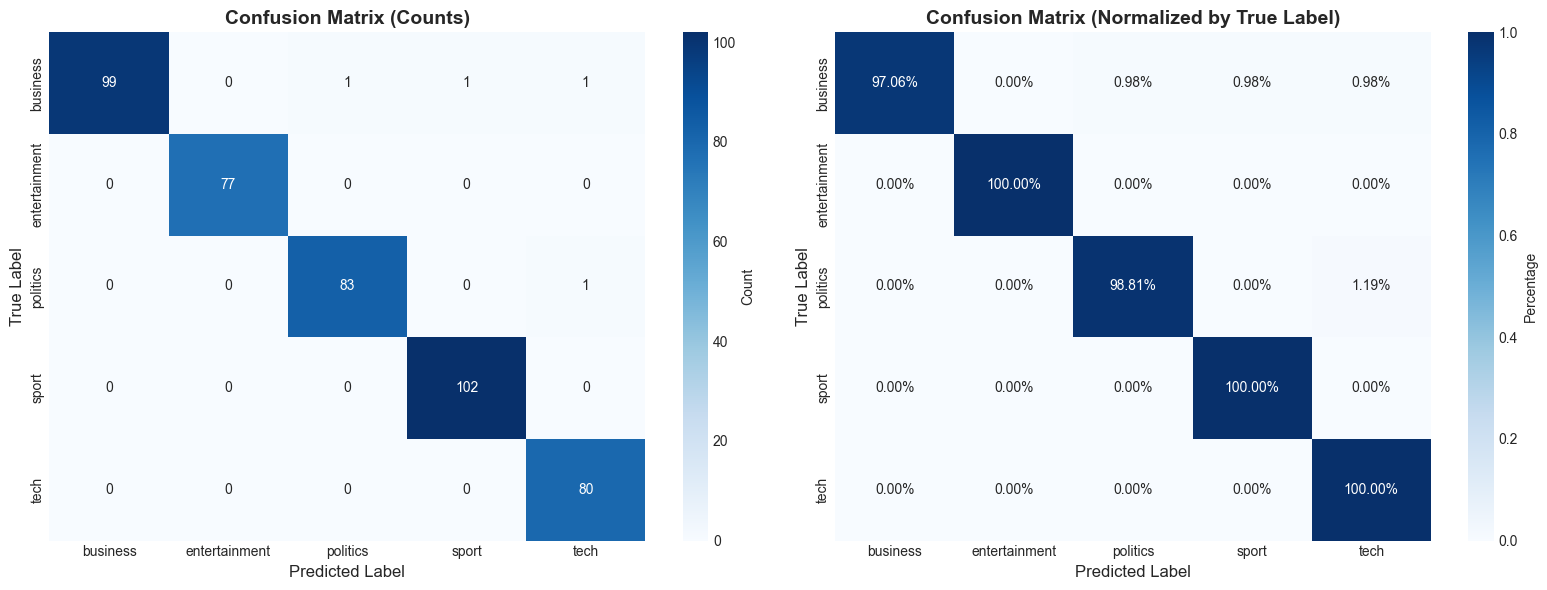


Saved: c:\CAS\cas-ml-document-classification\results\additional_analyses\confusion_matrix_normalized.png


In [12]:
# Visualisierung: Side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute Counts
sns.heatmap(cm_counts, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes, 
            ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Plot 2: Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=classes, yticklabels=classes, 
            ax=ax2, cbar_kws={'label': 'Percentage'}, vmin=0, vmax=1)
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_title('Confusion Matrix (Normalized by True Label)', fontsize=14, fontweight='bold')

plt.tight_layout()
p = RESULTS_DIR / "confusion_matrix_normalized.png"
plt.savefig(p, dpi=300, bbox_inches='tight')
plt.show()
print(f"\nSaved: {p}")

## 6. Summary für Transferarbeit

Alle Grafiken wurden gespeichert in: `results/additional_analyses/`

### Verwendung in Transferarbeit:

1. **Regularization Analyse** → Kapitel "Hyperparameter Tuning" oder "Methodik"
2. **Feature Importance** → Kapitel "Interpretierbarkeit" oder "Ergebnisse"
3. **Classification Report** → Kapitel "Evaluation" oder "Ergebnisse"
4. **Confusion Matrix** → Kapitel "Error Analysis" oder "Ergebnisse"

### Kernaussagen:

- ✅ **C-Parameter:** Default C=1.0 zeigt bereits optimale Performance
- ✅ **Feature Importance:** Klassenspezifische Schlüsselwörter sind gut interpretierbar
- ✅ **Metriken:** Alle Klassen erreichen >98% F1-Score
- ✅ **Fehleranalyse:** Kaum Verwechslungen zwischen Klassen

In [13]:
# Export Summary als CSV
summary = {
    'Best_C': [best_C],
    'Test_Accuracy': [results_df.loc[results_df['C'] == best_C, 'test_accuracy'].values[0]],
    'Test_F1_Macro': [results_df.loc[results_df['C'] == best_C, 'test_f1_macro'].values[0]],
    'Overall_Precision': [report_df.loc['macro avg', 'precision']],
    'Overall_Recall': [report_df.loc['macro avg', 'recall']],
    'Overall_F1': [report_df.loc['macro avg', 'f1-score']]
}

summary_df = pd.DataFrame(summary)
summary_path = RESULTS_DIR / "summary_metrics.csv"
summary_df.to_csv(summary_path, index=False)

print("\n" + "="*70)
print("SUMMARY METRICS")
print("="*70)
print(summary_df.T)
print(f"\nSaved: {summary_path}")


SUMMARY METRICS
                           0
Best_C             10.000000
Test_Accuracy       0.991011
Test_F1_Macro       0.991189
Overall_Precision   0.990799
Overall_Recall      0.991737
Overall_F1          0.991189

Saved: c:\CAS\cas-ml-document-classification\results\additional_analyses\summary_metrics.csv


In [14]:
# Liste aller erstellten Dateien
print("\n" + "="*70)
print("ERSTELTE DATEIEN FÜR TRANSFERARBEIT")
print("="*70)
for file in sorted(RESULTS_DIR.glob("*.png")):
    print(f"📊 {file.name}")
for file in sorted(RESULTS_DIR.glob("*.csv")):
    print(f"📄 {file.name}")


ERSTELTE DATEIEN FÜR TRANSFERARBEIT
📊 classification_report_per_class.png
📊 confusion_matrix_normalized.png
📊 regularization_c_parameter_analysis.png
📊 tfidf_feature_importance_per_class.png
📄 summary_metrics.csv
